In [44]:
from skimage.transform import resize


In [1]:
from torchvision import models

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [20]:
import numpy as np

In [4]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])


In [102]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cuda device


In [103]:
fcn = models.segmentation.fcn_resnet101(pretrained=True, progress = False).to(device).eval()

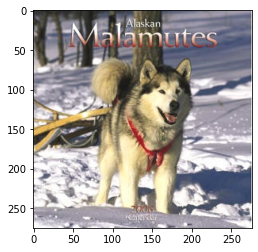

In [104]:
img = Image.open("CU_dogs/training_133/005.alaskan_malamute/alaskan_malamute_001.jpg")
plt.imshow(img)

In [105]:
inp = trf(img).unsqueeze(0).to(device)


In [106]:
out = fcn(inp)['out']

In [107]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(275, 276)
[ 0 12]


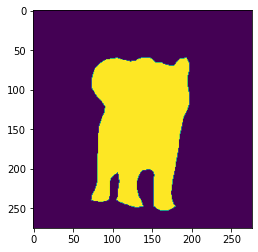

In [108]:
plt.imshow(om)

# Beagles - crop them and stuff

In [96]:
from skimage import io as skio

import scipy.io
import h5py

from glob import glob

In [101]:
from tqdm import tqdm

In [98]:
beagle_mats = glob('CU_dogs/training_133/016.beagle/*v4.mat')

beagle_mats.sort()

In [99]:
for idx, name in enumerate(beagle_mats):

    mat = scipy.io.loadmat(name)

    img = mat['Icrop']
    points = mat['parts']

    img = resize(img, (224, 224)) * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)

    trf = T.Compose([
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)

    out = fcn(inp)['out']

    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

    mask = (om == 12)





    img_masked = np.array(img) * np.stack([mask]*3, axis=2)

    skio.imsave(f"beagleheads/{idx}.jpg", img_masked)

### Other dogs

In [111]:
top_breeds = ['005.alaskan_malamute','015.basset_hound','029.border_collie','039.bull_terrier','057.dalmatian','041.bullmastiff','087.irish_terrier','056.dachshund','016.beagle','012.australian_shepherd']

In [113]:
for BREED in tqdm(top_breeds):
    mats = glob(f'CU_dogs/training_133/{BREED}/*v4.mat')
    mats.sort()
    
    for idx, name in enumerate(mats):

        mat = scipy.io.loadmat(name)

        img = mat['Icrop']
        points = mat['parts']
        
        scale_W = img.shape[1] / 224
        scale_H = img.shape[0] / 224

        points[0] = points[0]/scale_W
        points[1] = points[1]/scale_H

        img = resize(img, (224, 224)) * 255
        img = img.astype(np.uint8)
        img = Image.fromarray(img)

        trf = T.Compose([
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
        inp = trf(img).unsqueeze(0).to(device)

        out = fcn(inp)['out']

        om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

        mask = (om == 12)


        img_masked = np.array(img) * np.stack([mask]*3, axis=2)
        
        mat['Imask'] = img_masked
        mat['points'] = points
        
        out_dir = name[:-5] + '5.mat'
        scipy.io.savemat(out_dir, mat)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]
